<a href="https://colab.research.google.com/github/tangQAQ/LSTM_training/blob/main/Testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, TimeDistributed
from keras.callbacks import EarlyStopping
from google.colab import drive
import matplotlib.pyplot as plt
from keras.optimizers import Adam
import warnings 

warnings.filterwarnings('ignore')

drive.mount('/content/gdrive')
train_data = pd.read_csv("/content/gdrive/MyDrive/GSPC_train.csv", )
train_data = train_data.drop(['Date'], axis= 1)
train_data = train_data.apply(lambda x: pd.to_numeric(x.str.replace(',',''), errors='coerce')).fillna(-1).astype('float32')
print(train_data.info())
sc = MinMaxScaler(feature_range=(0,1))
train_data = sc.fit_transform(train_data.iloc[:, 3:4])


Mounted at /content/gdrive
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23683 entries, 0 to 23682
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       23683 non-null  float32
 1   High       23683 non-null  float32
 2   Low        23683 non-null  float32
 3   Close      23683 non-null  float32
 4   Adj Close  23683 non-null  float32
 5   Volume     23683 non-null  float32
dtypes: float32(6)
memory usage: 555.2 KB
None


In [2]:
train_data

array([[0.00278789],
       [0.00277954],
       [0.00274407],
       ...,
       [0.93566984],
       [0.9198628 ],
       [0.9167161 ]], dtype=float32)

In [3]:
size = int(len(train_data) * 0.8)
train, val = train_data[:size], train_data[size:]
train.shape, val.shape

((18946, 1), (4737, 1))

In [4]:
def create_sequences(data, sequences):
    X = []
    y = []
    for i in range(sequences, len(data)):
        X.append(data[i-sequences:i, :])
        y.append(data[i, 0])
    X = np.array(X)
    y = np.array(y)
    return X, y

In [5]:
sequences = 15
#train_data_scaled = sc.fit_transform(train.iloc[:, 3:4])
#val_data_scaled = sc.transform(val.iloc[:, 3:4])
#print(train_data_scaled.max(), train_data_scaled.min(), val_data_scaled.max(), val_data_scaled.min())

X_train, y_train = create_sequences(train, sequences)
X_val, y_val = create_sequences(val, sequences)
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((18931, 15, 1), (18931,), (4722, 15, 1), (4722,))

In [6]:
print(X_train[1] ,y_train[1])

[[0.00277954]
 [0.00274407]
 [0.00276702]
 [0.00273363]
 [0.0027065 ]
 [0.00270233]
 [0.00272737]
 [0.00275033]
 [0.00268981]
 [0.0026919 ]
 [0.00268355]
 [0.00270859]
 [0.00272946]
 [0.00276285]
 [0.00277745]] 0.002737805


In [7]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(units=50, return_sequences=True))
model.add(LSTM(units=50, return_sequences=True))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dense(units=1))

model.compile(optimizer='Adam', loss='mse')
callback = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, batch_size=32, callbacks = [callback])

Epoch 1/100
592/592 [==============================] - 23s 15ms/step - loss: 1.0264e-04 - val_loss: 0.0028
Epoch 2/100
592/592 [==============================] - 6s 11ms/step - loss: 1.2762e-05 - val_loss: 0.0035
Epoch 3/100
592/592 [==============================] - 6s 9ms/step - loss: 1.2409e-05 - val_loss: 0.0052
Epoch 4/100
592/592 [==============================] - 7s 11ms/step - loss: 1.2235e-05 - val_loss: 0.0044
Epoch 5/100
592/592 [==============================] - 6s 9ms/step - loss: 1.7034e-05 - val_loss: 0.0073
Epoch 6/100
592/592 [==============================] - 7s 11ms/step - loss: 1.0843e-05 - val_loss: 0.0054
Epoch 7/100
592/592 [==============================] - 6s 9ms/step - loss: 1.2338e-05 - val_loss: 0.0083
Epoch 8/100
592/592 [==============================] - 6s 11ms/step - loss: 1.1248e-05 - val_loss: 0.0090
Epoch 9/100
592/592 [==============================] - 6s 10ms/step - loss: 9.7150e-06 - val_loss: 0.0066
Epoch 10/100
592/592 [==========================

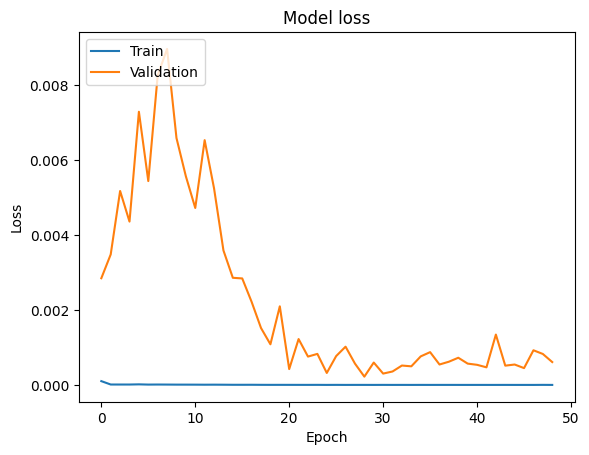

In [8]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [9]:
model.evaluate(X_train, y_train, batch_size= 32)

592/592 [==============================] - 2s 4ms/step - loss: 7.2541e-06


7.254112006194191e-06

In [10]:
test_df = pd.read_csv("/content/gdrive/MyDrive/GSPC_train.csv")

test_data = test_df.copy()
test_data = test_data.drop(['Date'], axis= 1)
test_data_clean = test_data.apply(lambda x: pd.to_numeric(x.str.replace(',',''), errors='coerce')).fillna(-1).astype('float32')

preds = list()
days = 100 #len(test_data_clean)
sc2 = MinMaxScaler(feature_range=(0,1))
test_data= sc2.fit_transform(test_data_clean.iloc[:sequences, 3:4])
'''
for i in range(1, days+1):
  test_data_scaled = sc2.transform(test_data)
  #print(f'test_data_scaled: {test_data_scaled}')
  X_test, y_test = create_sequences(test_data_scaled, sequences)
  #print(f'X_test: {X_test}, X_test.shape: {X_test.shape}')
  test_predictions = model.predict(X_test)
  #print(f'test_predictions: {test_predictions}')
  inverse = sc.inverse_transform(test_predictions)
  #print(f'inverse: {inverse}')
  preds.append(inverse[:, 0])
  #print(f'preds: {preds}')
  test_data.drop(0, inplace=True)
  #print(f'test_data: {test_data}')
  test_data = test_data.append(pd.Series(inverse[:,0], index=test_data.columns), ignore_index=True)
  #print(f'test_data: {test_data}')
  if i % 1000 == 0 :
    print(i)
'''

ValueError: ignored

In [ ]:
preds

In [ ]:
model.evaluate(X_test, y_test, batch_size= 32)

In [ ]:
from numpy.ma import left_shift
import matplotlib.ticker as ticker


limit = sequences + days
Actual_Close = test_data_clean['Close']#.drop(sequences)
seq_Close = test_data_clean['Close'].iloc[:sequences]
result = preds

plt.figure(figsize=(12, 8))
plt.title('Actual vs. Predicted Closing Prices')
plt.xlabel('Time line')
plt.ylabel('Closing Price')
plt.plot(result, label='Predicted Close', color='b', linestyle='--')
plt.plot(Actual_Close, label='Actual Close', color='r')
plt.plot(seq_Close, label='Sequences', color='y')
#plt.xlim([0,days])
#plt.ylim([15, 50])
ax= plt.gca()
#ax.xaxis.set_major_locator(ticker.MultipleLocator(100))
#ax.yaxis.set_major_locator(ticker.MultipleLocator(100))
plt.legend()
plt.show()

In [11]:
test_df = pd.read_csv("/content/gdrive/MyDrive/GSPC_test.csv")

test_data = test_df.copy()
test_data = test_data.drop(['Date'], axis= 1)
test_data_clean = test_data.apply(lambda x: pd.to_numeric(x.str.replace(',',''), errors='coerce')).fillna(-1).astype('float32')

preds = list()
days = len(test_data_clean)
sc2 = MinMaxScaler(feature_range=(0,1))
#test_data = sc2.fit_transform(test_data_clean.iloc[:, 3:4])

print(test_data.shape)
test_data_scaled = sc2.fit_transform(test_data_clean.iloc[:, 3:4])
print(test_data_scaled.max(), test_data_scaled.min())

#print(f'test_data_scaled: {test_data_scaled}')

X_test, y_test = create_sequences(test_data_scaled, sequences)
print(f'X_test: {X_test}, X_test.shape: {X_test.shape}')
test_predictions = model.predict(X_test)

#print(f'test_predictions: {test_predictions}')

inverse = sc2.inverse_transform(test_predictions)

#print(f'inverse: {inverse}')
#preds.append(inverse[:, 0])
#print(f'preds: {preds}')
#test_data.drop(0, inplace=True)
#print(f'test_data: {test_data}')
#test_data = test_data.append(pd.Series(inverse[:,0], index=test_data.columns), ignore_index=True)
#print(f'test_data: {test_data}')


(250, 6)
1.0 0.0
X_test: [[[0.9823537 ]
  [0.92134905]
  [0.92033243]
  ...
  [0.6533699 ]
  [0.67607737]
  [0.81694126]]

 [[0.92134905]
  [0.92033243]
  [1.        ]
  ...
  [0.67607737]
  [0.81694126]
  [0.6437564 ]]

 [[0.92033243]
  [1.        ]
  [0.99688244]
  ...
  [0.81694126]
  [0.6437564 ]
  [0.6171737 ]]

 ...

 [[0.38366175]
  [0.42312288]
  [0.4810772 ]
  ...
  [0.59148407]
  [0.5799384 ]
  [0.5964775 ]]

 [[0.42312288]
  [0.4810772 ]
  [0.4066291 ]
  ...
  [0.5799384 ]
  [0.5964775 ]
  [0.60109806]]

 [[0.4810772 ]
  [0.4066291 ]
  [0.41990328]
  ...
  [0.5964775 ]
  [0.60109806]
  [0.6009059 ]]], X_test.shape: (235, 15, 1)
8/8 [==============================] - 1s 4ms/step


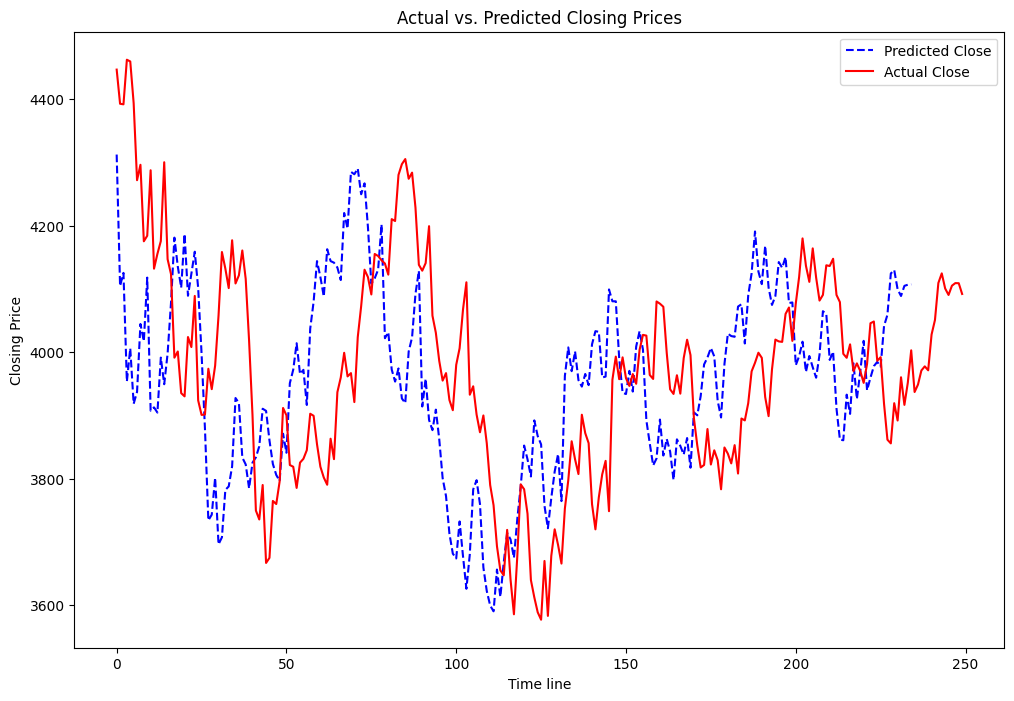

In [12]:
from numpy.ma import left_shift
import matplotlib.ticker as ticker


limit = sequences + days
Actual_Close = test_data_clean['Close']#.drop(sequences)
seq_Close = test_data_clean['Close'].iloc[:sequences]
result = inverse

plt.figure(figsize=(12, 8))
plt.title('Actual vs. Predicted Closing Prices')
plt.xlabel('Time line')
plt.ylabel('Closing Price')
plt.plot(result, label='Predicted Close', color='b', linestyle='--')
plt.plot(Actual_Close, label='Actual Close', color='r')
#plt.plot(seq_Close, label='Sequences', color='y')
#plt.xlim([0,days])
#plt.ylim([15, 50])
ax= plt.gca()
#ax.xaxis.set_major_locator(ticker.MultipleLocator(100))
#ax.yaxis.set_major_locator(ticker.MultipleLocator(100))
plt.legend()
plt.show()